# Final correlation analysis - TRAF2 Inhibitors 2 + 5

In [1]:
%matplotlib inline
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

***
## Introduction
We predicted several TRAF2 inhibitors, ten of which were tested, and two of which showed reproducible inhibition of the canonical NFkB pathway. These hits, cpds 2 and 5, are listed below, along with three negative controls (cpds 6, 11, & 9). In this document we will compare the perturbational mRNA signatures of these five cpds to the knockdown signatures of TRAF2 and the proteins involved in the canonical NFkB pathway

In [2]:
# negative controls, cpds 6, 11, & 9
cntrl_cpds = ['BRD-K91047982','BRD-K60762818','BRD-K35687265']
# hits - cpds 2 & 5
hit_cpds = ['BRD-K95352812','BRD-A09719808']

***
First, we need to read in the complete dataset of consensus mRNA signatures from the LINCS L1000 experiments. A consensus mRNA signature is essentially a weighted average mRNA profile of a particular perturbagen (drug, knockdown, etc...) taken accross multiple experiments (often in multiple cell lines).

We acquired the consensus signature dataset from (https://github.com/dhimmel/lincs/), which we here load into a Pandas DataFrame (below). The dataframe has 978 rows, each representing a landmark gene whos expression was measured in the LINCS experiments. The ~40,000 columns represent unique perturbagens, including bioactive compounds, gene knockdowns, and gene overexpressions. 

In [33]:
consensi_df = pd.DataFrame.from_csv('consensi-pert_id.tsv', sep='\t', header=0).T
cntrl_cpd_signatures = consensi_df[cntrl_cpds]
hit_cpd_signatures = consensi_df[hit_cpds]
all_cpd_signatures = pd.concat([hit_cpd_signatures, cntrl_cpd_signatures], axis=1)
cpd_col_order = all_cpd_signatures.columns.tolist()

***
## mRNA perturbation: Z-score distributions

The first thing we can do is look at the mRNA signatures themselves: how do these compounds affect gene expression in the cell overall? Below we plot the Z-score distributions for the different compounds. As we can see, all five distributions center around zero, but compounds 2 & 5 produce much wider distributions, meaning that cpds 2 & 5 tend to up-regulate and down-regulate more genes.

The means and standard deviations of the distributions are shown below, along with the plots.

<IPython.core.display.Javascript object>


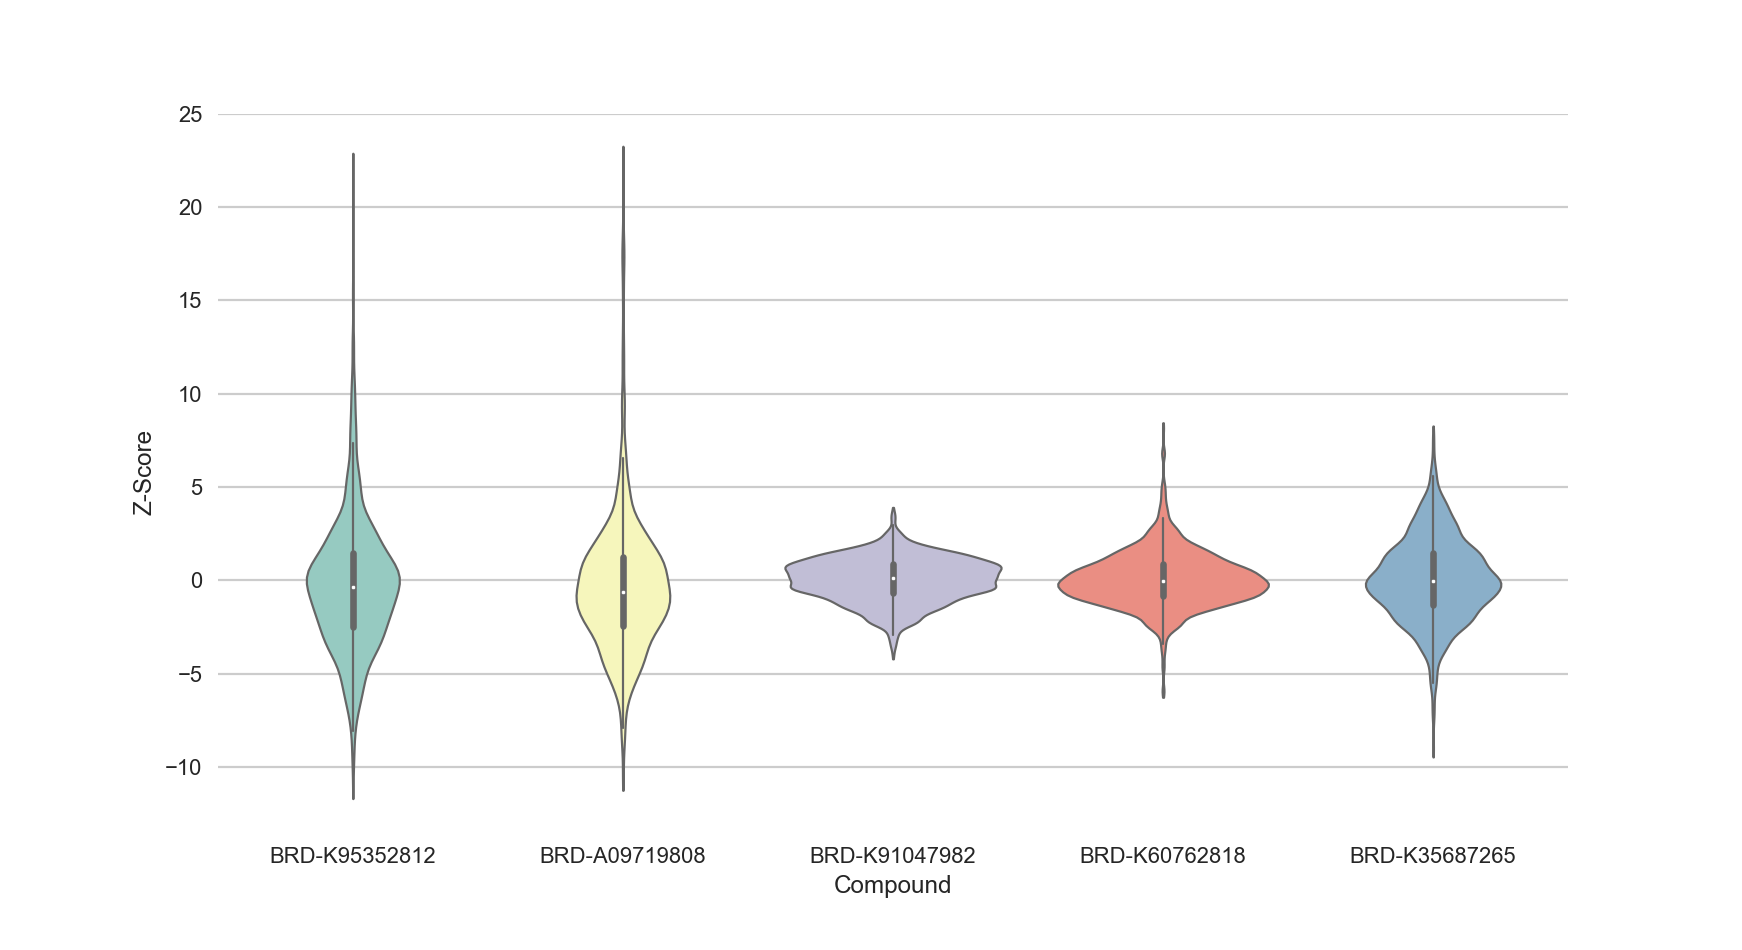

/Users/Nico/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


,Mean,Std Dev
perturbagen,,
BRD-K95352812,-0.282761,3.553105
BRD-A09719808,-0.330593,3.676701
BRD-K91047982,0.037092,1.174678
BRD-K60762818,0.064209,1.458907
BRD-K35687265,0.047756,2.225955


In [26]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(all_cpd_signatures, palette="Set3", bw=.2, cut=1, linewidth=1)
#ax.set(ylim=(-.7, 1.05))
plt.ylabel("Z-Score")
plt.xlabel("Compound")
sns.despine(left=True, bottom=True)

d = { 'Mean': np.mean(all_cpd_signatures), 'Std Dev' :  np.std(all_cpd_signatures) }
pd.DataFrame(d)

***
## Cpd - cpd correlations in mRNA signatures

We can further compare the five Z-score distributions by computing their pairwise pearson correlations. Do these compounds tend to up/down regulate the same genes? To what degree do their transcriptional perturbations match each other?

As we can see from the heatmap below, cpds 2 and 5 produce highly correlated transcriptional perturbations. This makes sense, as we predict these two compounds to target the same protein. No other pairs of compounds produce significantly correlated signatures.

<IPython.core.display.Javascript object>


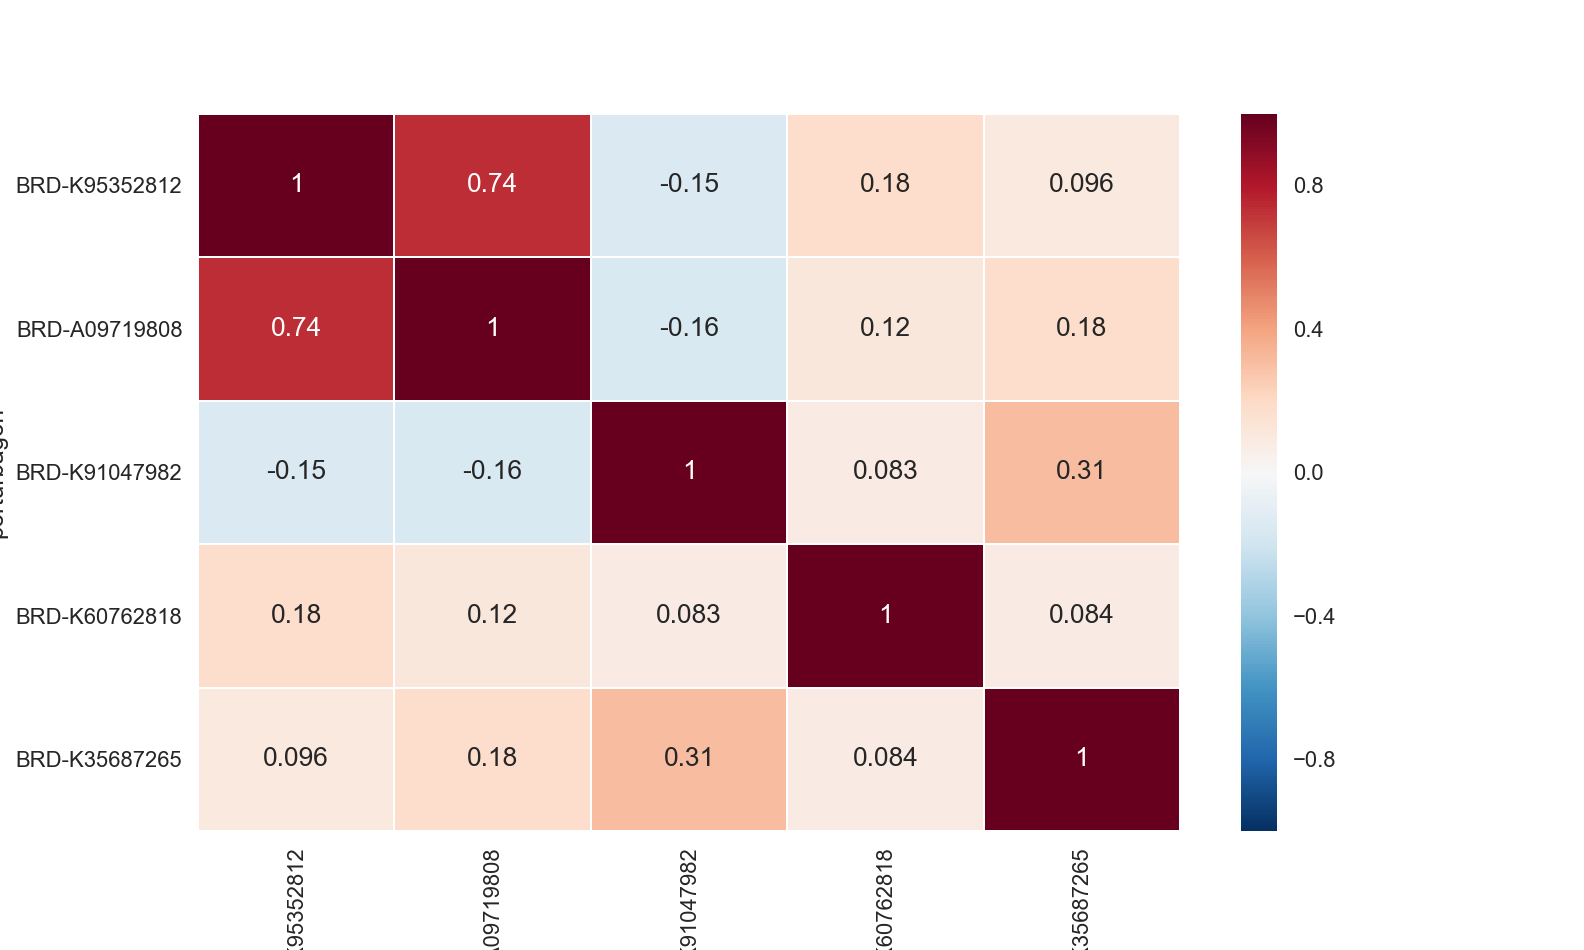

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text yticklabel objects>)

In [12]:
cpd_cpd_corrs = all_cpd_signatures.corr()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cpd_cpd_corrs, annot=True, linewidths=.5, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

To get a different feel for this data, we can plot the pairwise mRNA profiles. Each row/column in the grid below represents a different compound. Each point on the plots represents one of the 978 landmark genes measured in the LINCS L1000 assays. Once again, we can see that cpds 2 and 5 are the only ones that show noticable correlation in their distributions.

<IPython.core.display.Javascript object>


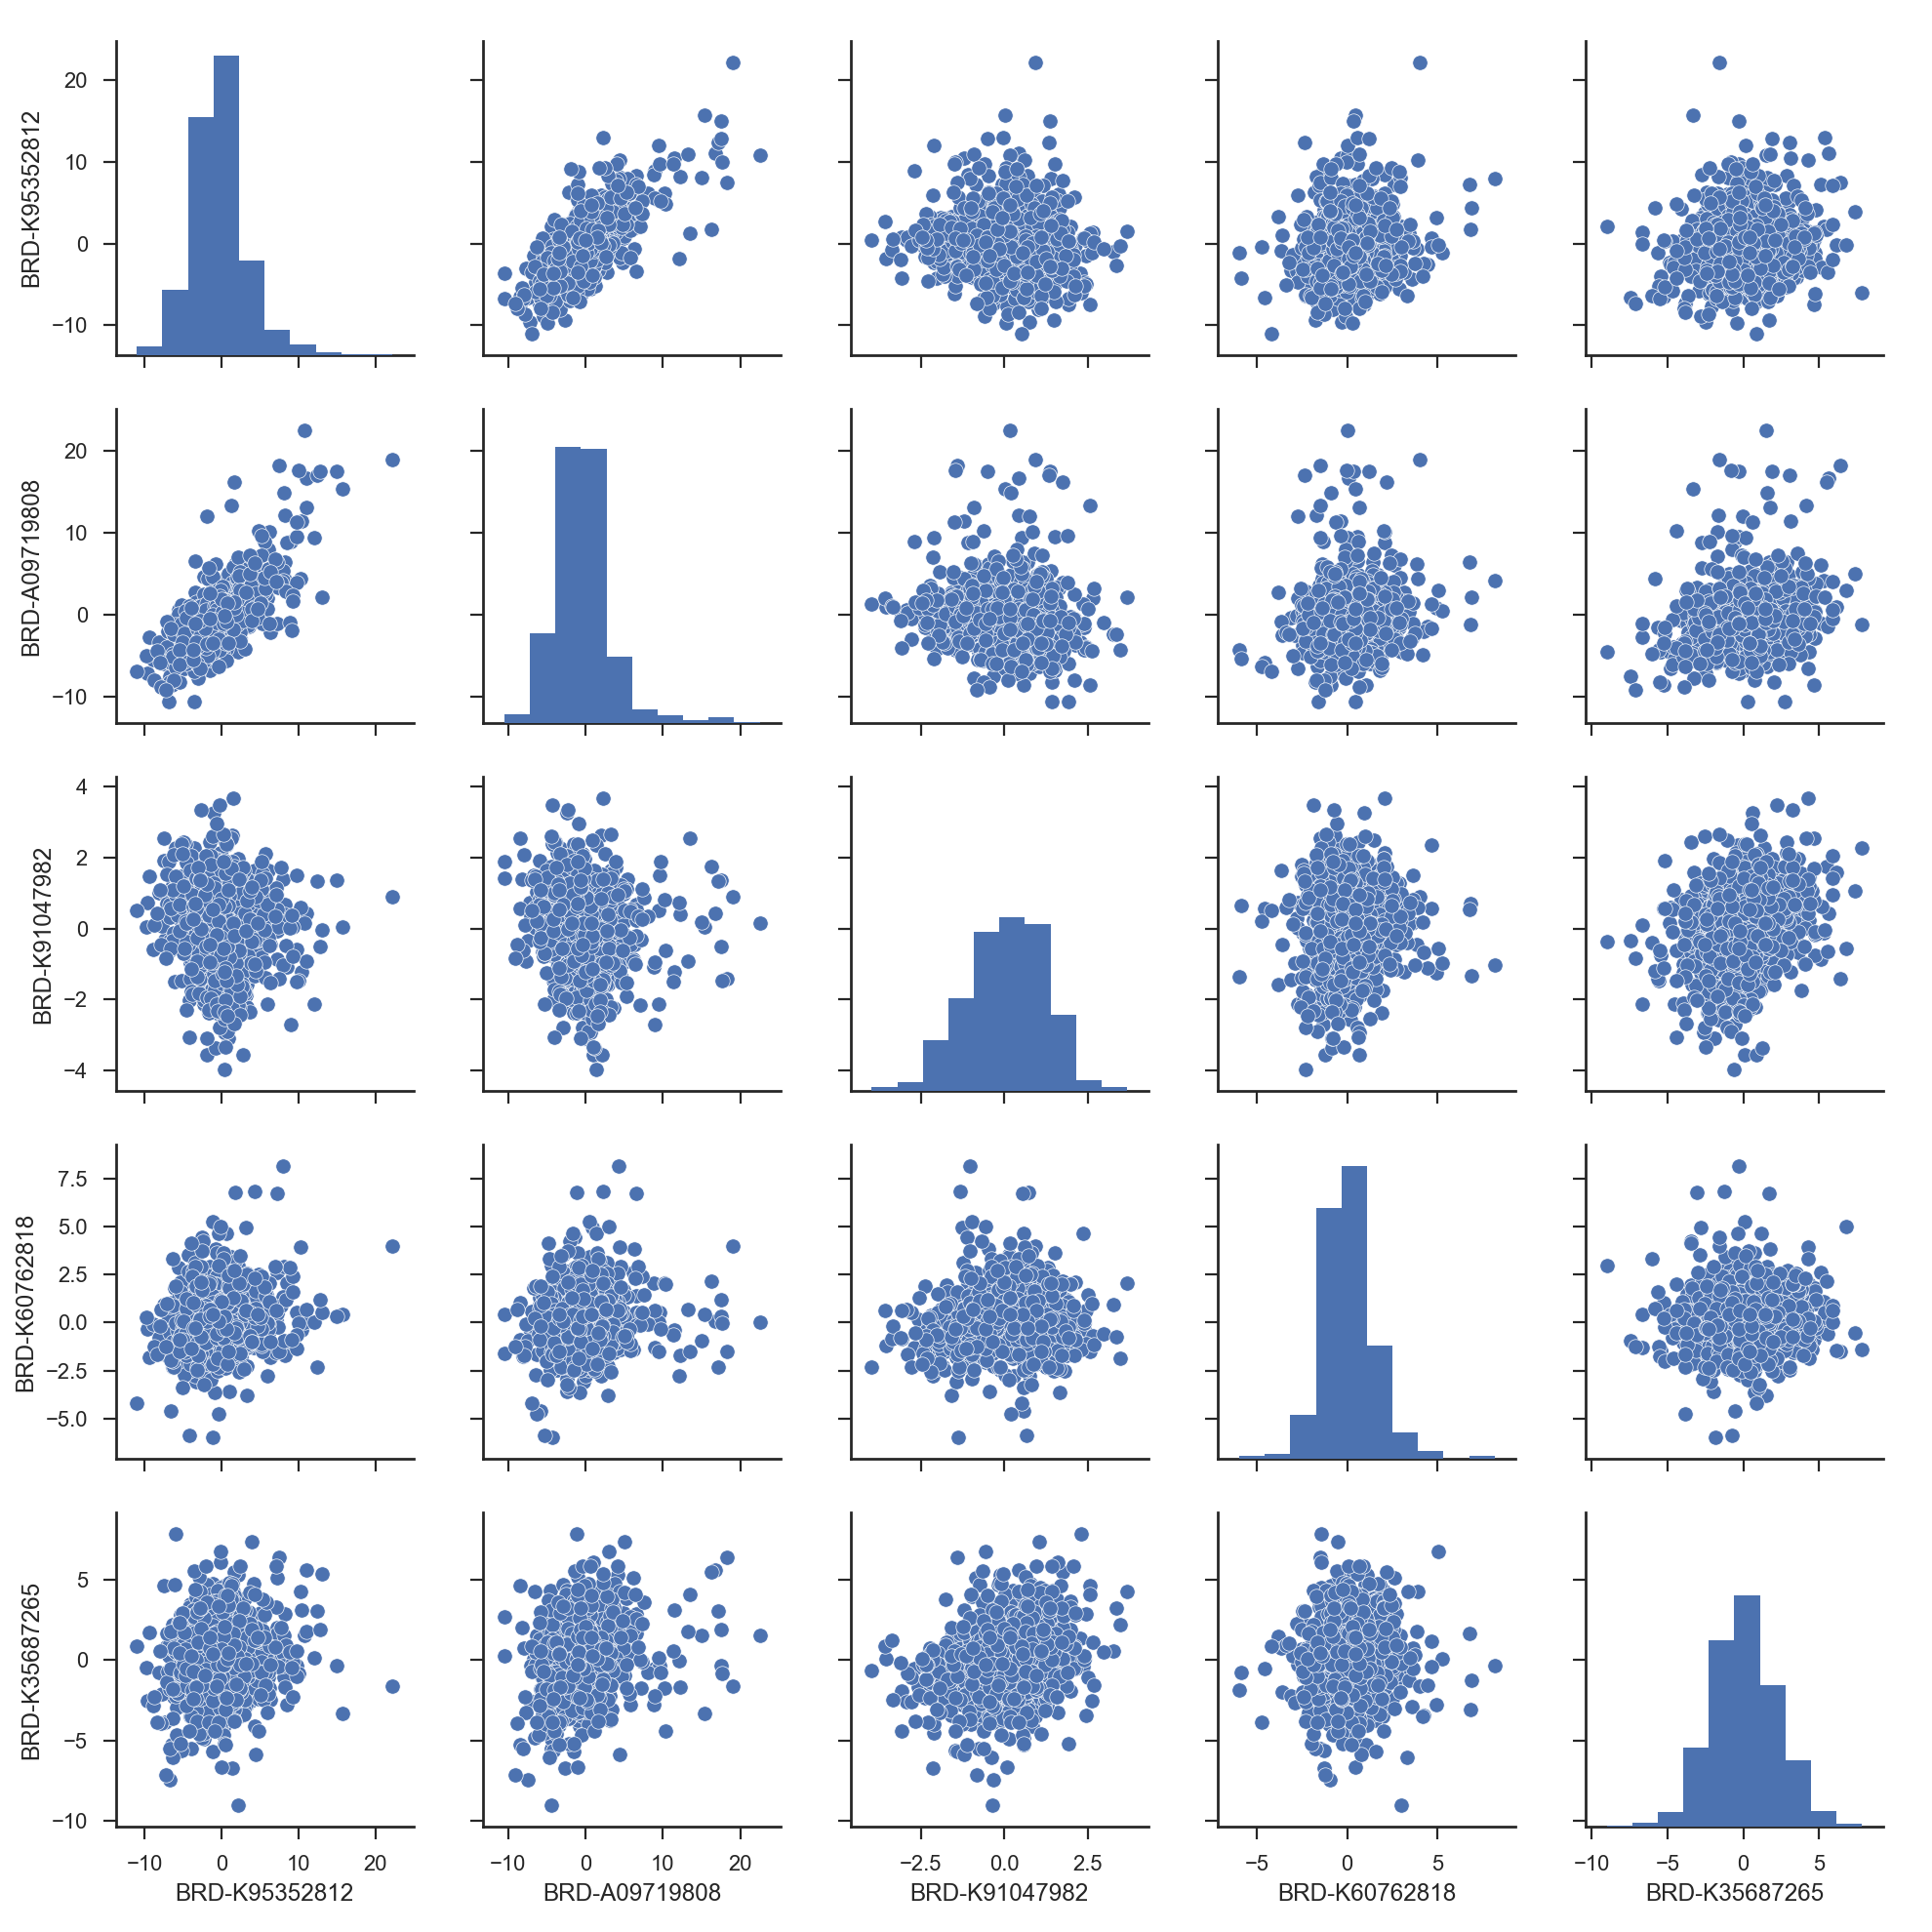

In [13]:
sns.set(style="ticks")
sns.pairplot(all_cpd_signatures)

***
## Cpd - knockdown correlations in mRNA signatures

The next question we will ask is whether the transcriptional pertubations produced by these five compounds correlate with the knockdowns of genes known to interact with TRAF2. If our compounds are indeed TRAF2 inhibitors, we would expect similar mRNA expression resulting from treatment with the inhibitor and knockdown of TRAF2 or its interaction partners.

First, we extract a list proteins that interact with TRAF2 from the BioGrid Database. Then we cross-reference these genes with the list of knockdowns performed in the LINCS L1000 assays. Ultimately we find transcriptional signatures from knockdowns of 142 different TRAF2 interaction partners. This includes genes from the canonical NFkB pathway as well as other pathways that TRAF2 is involved with.

In [40]:
# extract TRAF2 interaction partners from Biogrid.
Biogrid_df = pd.DataFrame.from_csv('BIOGRID-GENE-113038-3.4.153.tab2.txt', sep='\t', header=0)
TRAF2_partners = set(Biogrid_df[['Official Symbol Interactor A','Official Symbol Interactor B']].values.flatten())

# read in the LINCS knockdown dataset
KD_consensi_df = pd.DataFrame.from_csv('KD_consensus_sigs.csv', header=0).T
# not all the TRAF2 partners have KD data, so take the union of the two gene sets
LINCS_partner_genes = set(KD_consensi_df.columns) & TRAF2_partners
TRAF2_partner_signatures = KD_consensi_df[list(LINCS_partner_genes)]

# construct a new matrix with the cpd-partner correlations
corr_dict = {}
for cpd in all_cpd_signatures: 
    cpd_sig = all_cpd_signatures[cpd]
    corr_dict[cpd] = TRAF2_partner_signatures.corrwith(cpd_sig)
cpd_partner_corrs = pd.DataFrame(corr_dict)
cpd_partner_corrs = cpd_partner_corrs[cpd_col_order] # rearrange column order
#cpd_partner_corrs = cpd_partner_corrs.reindex([cpd_col_order]) # rearrange row order

# construct a full matrix with the cpd-KD correlations
full_corr_dict = {}
for cpd in all_cpd_signatures:
    cpd_sig = all_cpd_signatures[cpd]
    full_corr_dict[cpd] = KD_consensi_df.corrwith(cpd_sig)
all_cpd_corrs = pd.DataFrame(full_corr_dict)
all_cpd_corrs = all_cpd_corrs[cpd_col_order] # rearrange column order
#all_cpd_corrs = all_cpd_corrs.reindex([cpd_col_order]) # rearrange row order

***
Below we plot the distribution of Pearson correlation values for our five compound mRNA signatures compared against the 142 knockdown signatures from TRAF2 interactions partners. The means and standard deviations of the distributions are also shown. 

As we can see, cpds 2 (BRD-K95352812) and 5 (BRD-A09719808) show higher mean correlations with TRAF2 interaction partner knockdowns than our three control compounds.

<IPython.core.display.Javascript object>


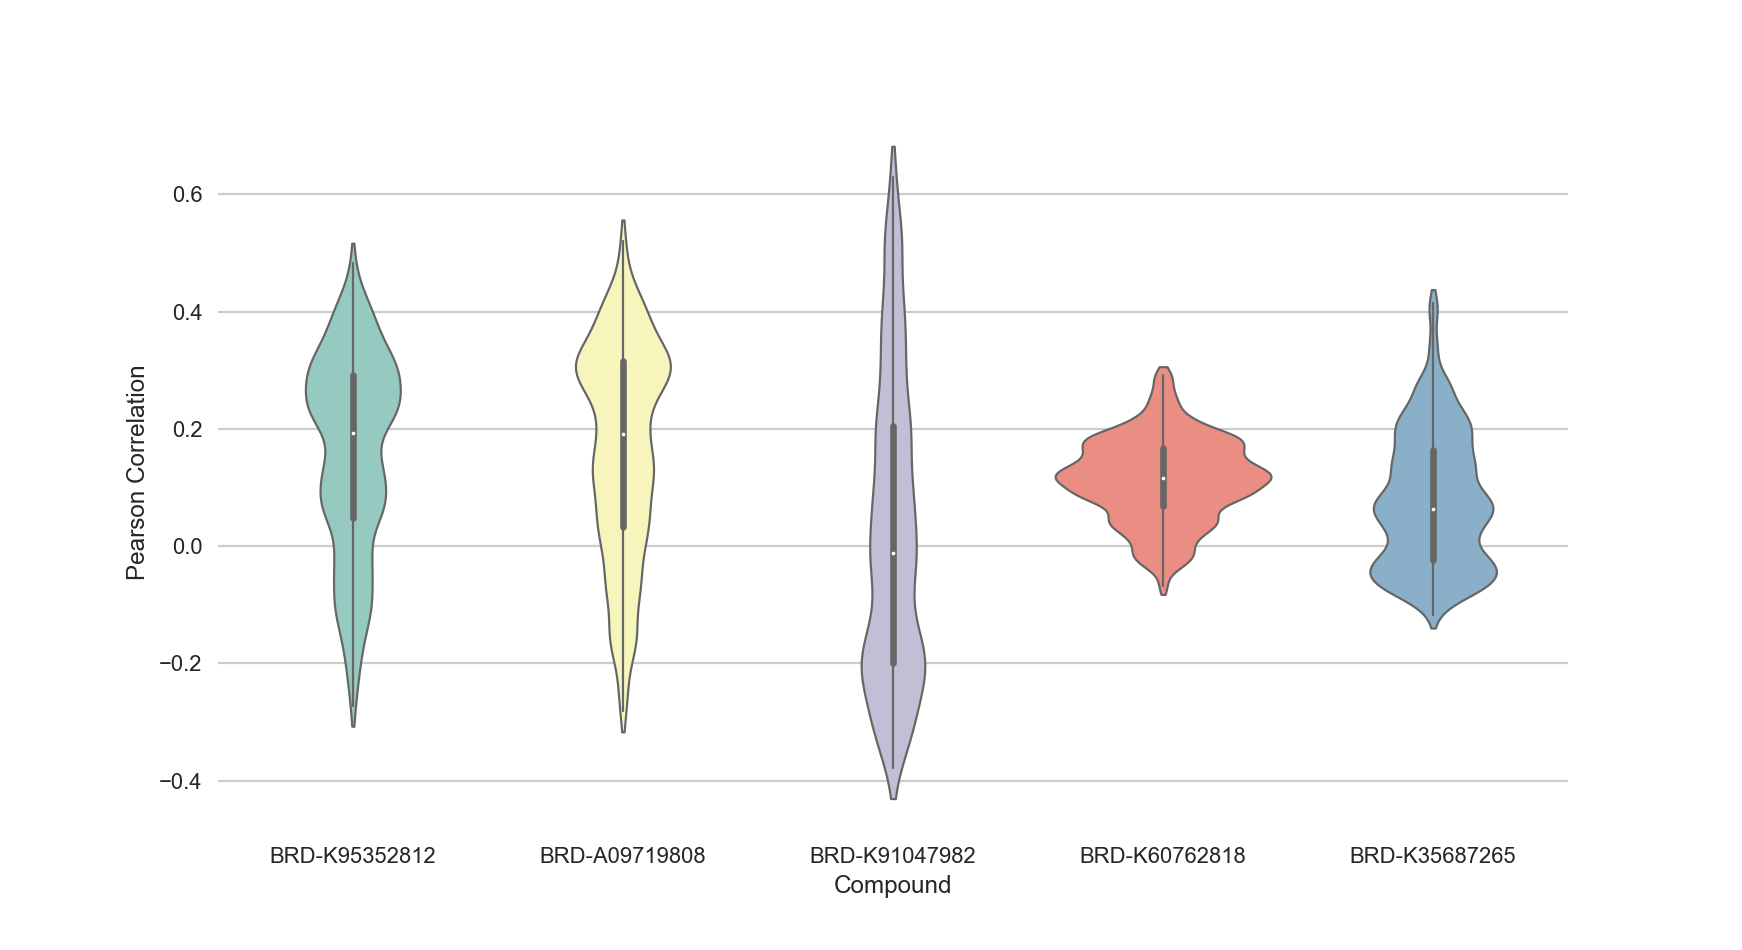

/Users/Nico/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


,Mean,Std Dev
BRD-K95352812,0.158425,0.170126
BRD-A09719808,0.167115,0.181437
BRD-K91047982,0.025000,0.258197
BRD-K60762818,0.114349,0.071955
BRD-K35687265,0.078152,0.114517


In [41]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(cpd_partner_corrs, palette="Set3", bw=.2, cut=1, linewidth=1)
#ax.set(ylim=(-.7, 1.05))
plt.ylabel("Pearson Correlation")
plt.xlabel("Compound")
sns.despine(left=True, bottom=True)

d = { 'Mean': np.mean(cpd_partner_corrs), 'Std Dev' :  np.std(cpd_partner_corrs) }
pd.DataFrame(d)

The knockdowns with which each compound correlates and those with which it does not correlate can be thought of as a different type of 'signature' for the compound - a correlation signature. We can compute the pairwise correlations between these signatures to see which compounds tend to mimic the same sets of knockdowns. 

As can be seen in the heatmap below, our two hits tend to correlate with the same sets of knockdowns (correlations of 0.97), while our three controls seem to loosely correlate with a different set of knockdowns.

<IPython.core.display.Javascript object>


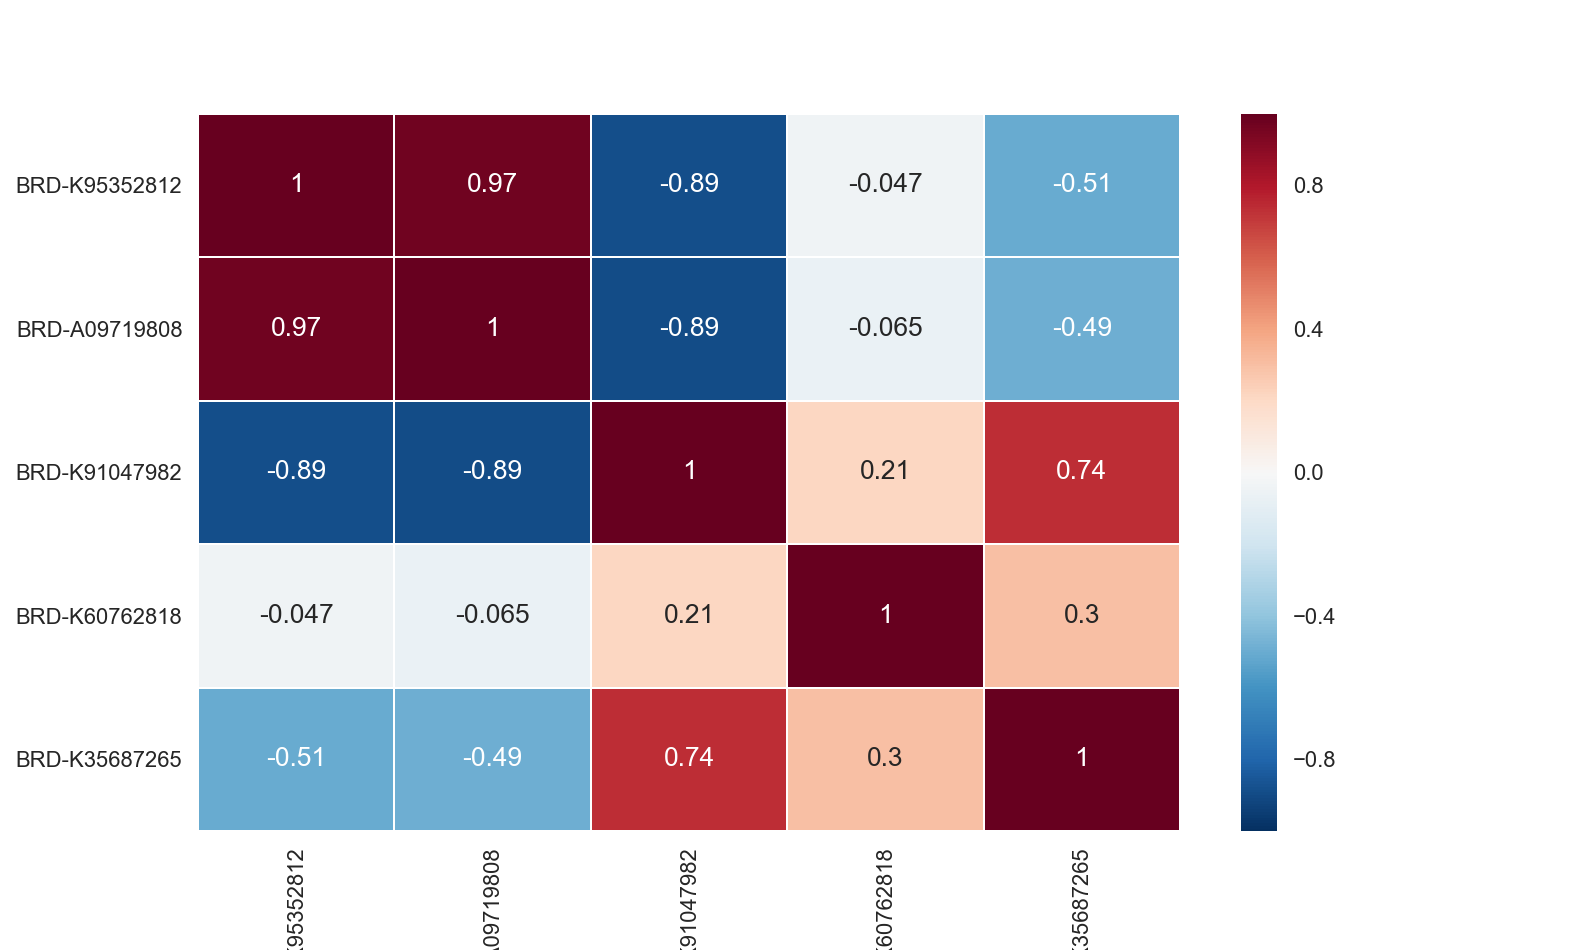

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text yticklabel objects>)

In [42]:
cpd_partner_corr_corrs = cpd_partner_corrs.corr()
cpd_partner_corr_corrs = cpd_partner_corr_corrs[cpd_col_order] # rearrange column order
cpd_partner_corr_corrs = cpd_partner_corr_corrs.reindex([cpd_col_order]) # rearrange row order
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cpd_partner_corr_corrs, annot=True, linewidths=.5, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

***
## Correlations within the canonical NFkB pathway

We can now narrow our focus to the genes in the canonical NFkB pathway that have been profiled in LINCS. The list of these genes is below. Once again we can compute correlation distributions as well as correlation heatmaps. 

We observe much the same results as above, with cpds 2 & 5 producing higher-than average correlations with knockdowns in the NFkB pathway, and tending to correlate with the same sets of knockdowns.

                   Mean   Std Dev
BRD-K95352812  0.183612  0.183186
BRD-A09719808  0.191904  0.207516
BRD-K91047982 -0.000603  0.269582
BRD-K60762818  0.098308  0.074145
BRD-K35687265  0.085927  0.131929


<IPython.core.display.Javascript object>


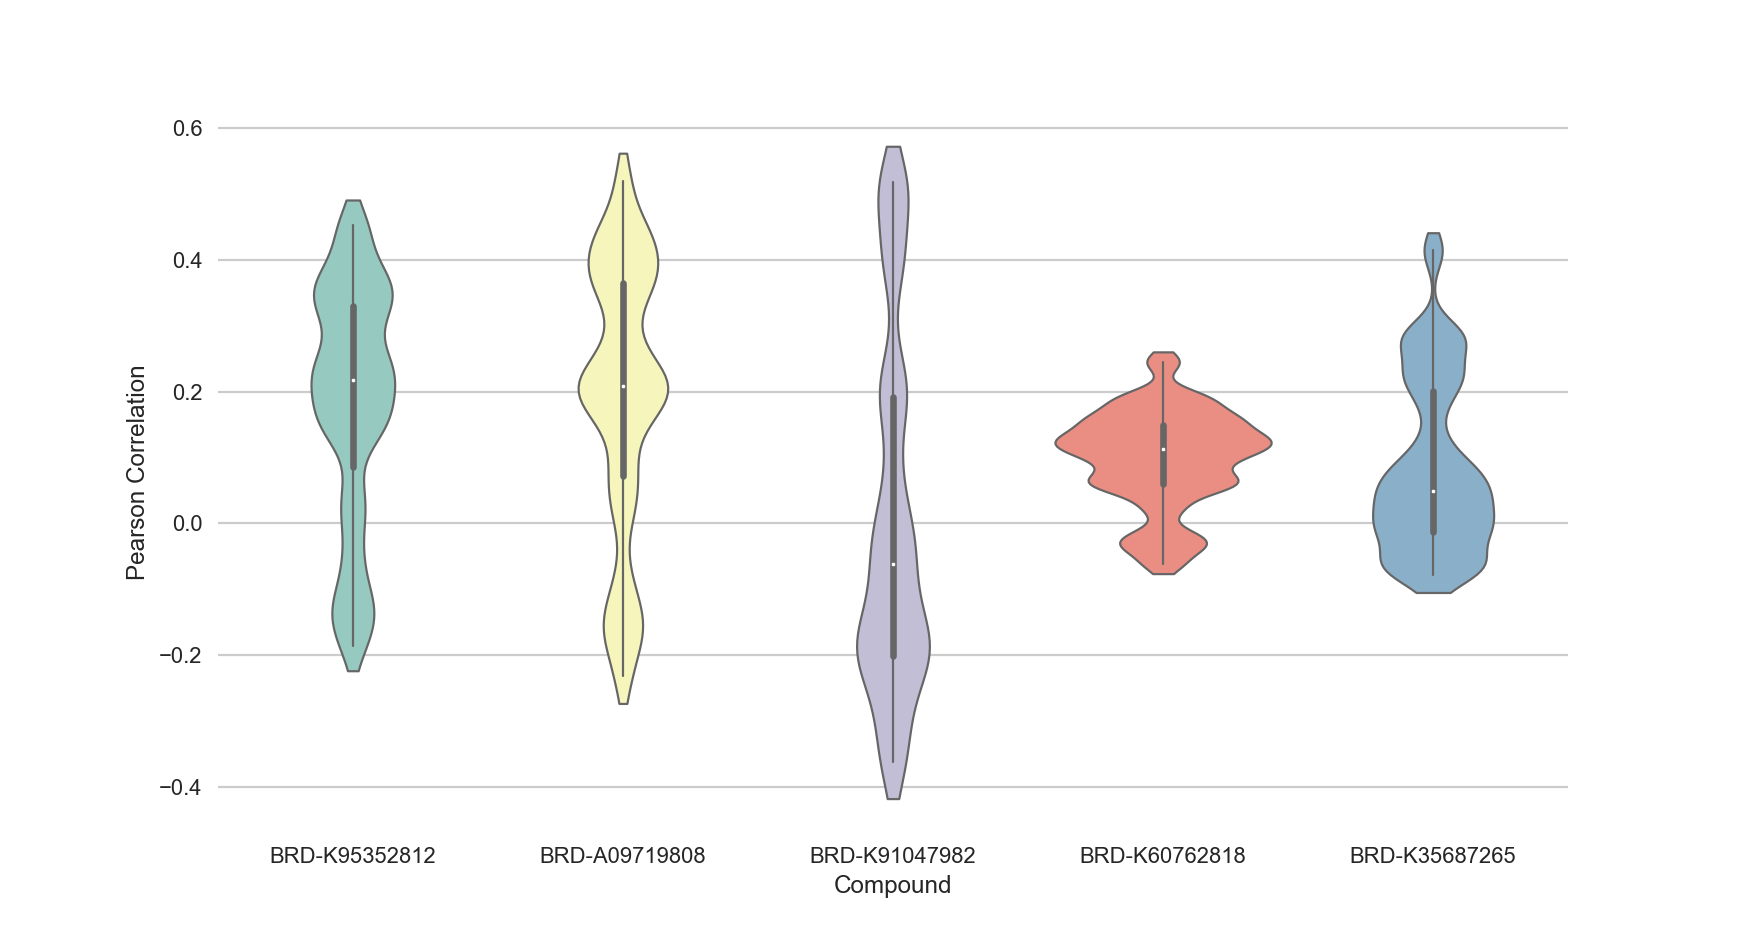

/Users/Nico/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


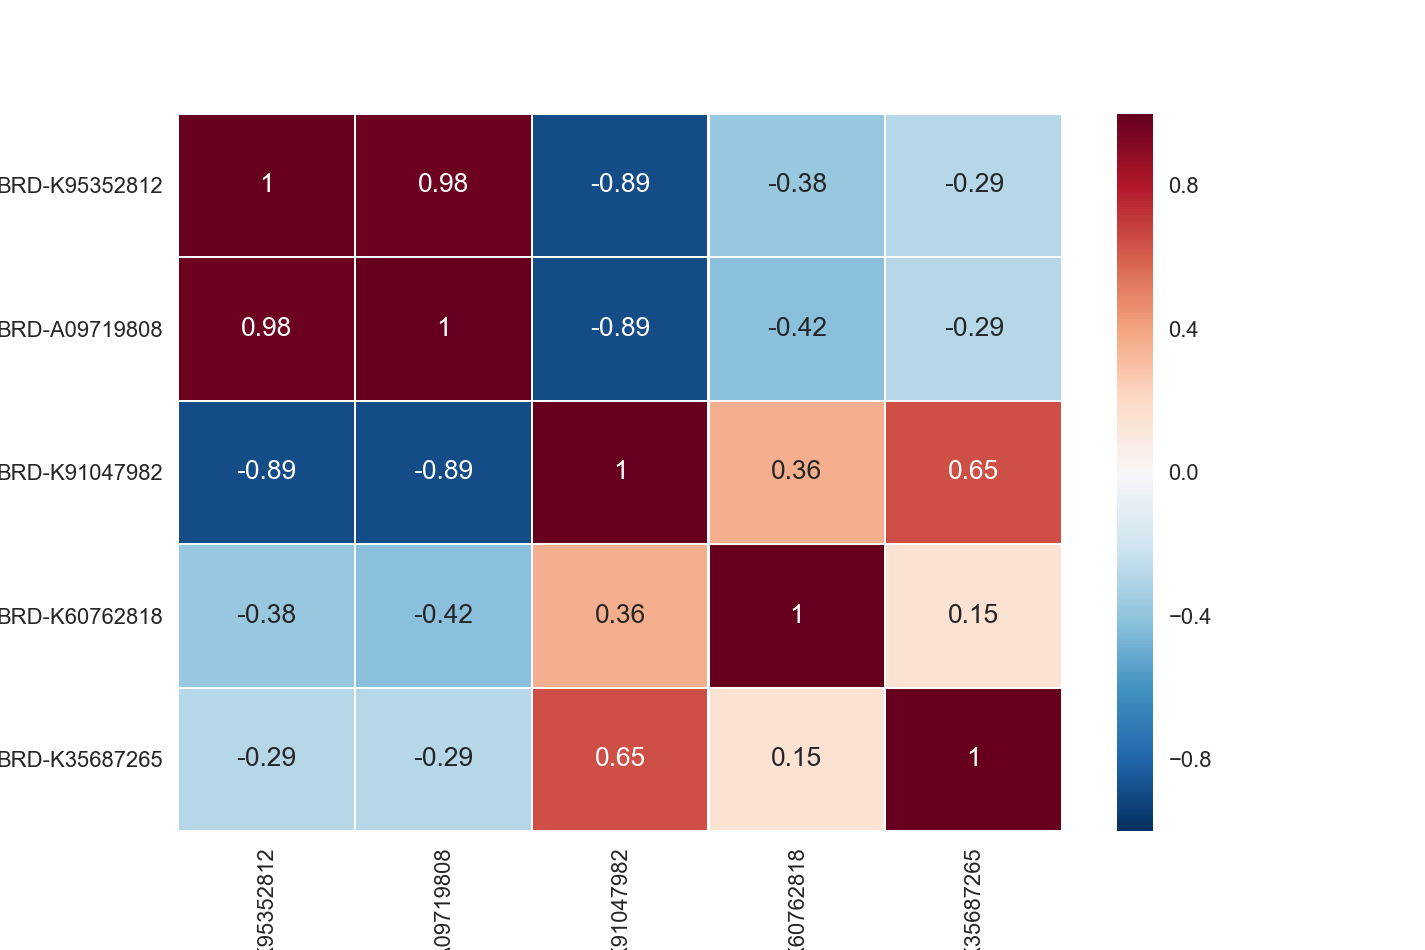

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text xticklabel objects>)

In [43]:
NFkB_pathway=['TRAF2','TRAF5','TRAF6','TNFRSF1A','TRADD','RIPK1','UBE2D1','BIRC2','BIRC3','UBB','UBC','UBA52','RPS27A','TAB2','TAB3','MAP3K7','IKBKG','RBCK1','CHUK','IKBKB','RELA','RELB','NFKBIA','NFKB1','NFKB2','CYLD','TNFAIP3']
NFkB_signatures = KD_consensi_df[NFkB_pathway]

cpd_NFkB_corrs_d = {}
for cpd in all_cpd_signatures:
    cpd_sig = all_cpd_signatures[cpd]
    cpd_NFkB_corrs_d[cpd] = NFkB_signatures.corrwith(cpd_sig)
cpd_NFkB_corrs = pd.DataFrame(cpd_NFkB_corrs_d)
cpd_NFkB_corrs = cpd_NFkB_corrs[cpd_col_order] # reorder columns

d = { 'Mean': np.mean(cpd_NFkB_corrs), 'Std Dev' :  np.std(cpd_NFkB_corrs) }
print(pd.DataFrame(d))

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(cpd_NFkB_corrs, palette="Set3", bw=.2, cut=1, linewidth=1)
#ax.set(ylim=(-.7, 1.05))
plt.ylabel("Pearson Correlation")
plt.xlabel("Compound")
sns.despine(left=True, bottom=True)


cpd_NFkB_corr_corrs = cpd_NFkB_corrs.corr()
cpd_NFkB_corr_corrs = cpd_NFkB_corr_corrs[cpd_col_order] # reorder columns
cpd_NFkB_corr_corrs = cpd_NFkB_corr_corrs.reindex([cpd_col_order]) # reorder rows

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(cpd_NFkB_corr_corrs, annot=True, linewidths=.5, ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)



***
## Most highly correlated knockdowns in the NFkB Pathway

The last thing we will look at is which knockdowns in the NFkB pathway our compounds correlate with the most and the least. As can be seen in the sorted table below, cpds 2 (BRD-K95352812) & 5 (BRD-A09719808) both correlate most highly with **UBC, UBB, RBCK1, UBE2D1**, and **RIPK1**. The correlate the least with **TRAF2, CHUK, CYLD**, and **RELA**.

In [46]:
cpd_dict = {}
for cpd in cpd_NFkB_corrs:
    cpd_sig = cpd_NFkB_corrs[cpd]
    cpd_d = { 'gene' : cpd_sig.index.values, 'corr' : cpd_sig.values }
    cpd_df = pd.DataFrame(cpd_d)
    cpd_df.sort_values('corr', ascending=False, inplace=True)
    cpd_df = cpd_df.reset_index()
    cpd_dict[(cpd, 'gene')] = cpd_df['gene']
    cpd_dict[(cpd, 'corr')] = cpd_df['corr']
ranked_NFkB_KDs = pd.DataFrame(cpd_dict)
ranked_NFkB_KDs = ranked_NFkB_KDs[cpd_col_order]
ranked_NFkB_KDs

BRD-K95352812           BRD-A09719808           BRD-K91047982            \
            corr      gene          corr      gene          corr      gene   
0       0.454036     RBCK1      0.520176       UBC      0.518046     TRAF2   
1       0.440689       UBC      0.448156       UBB      0.509228      CYLD   
2       0.388408    UBE2D1      0.435528    UBE2D1      0.494623     TRAF6   
3       0.375078       UBB      0.431772     RBCK1      0.408350      CHUK   
4       0.354807     RIPK1      0.396465    RPS27A      0.396173      RELA   
5       0.354793      TAB2      0.395371     RIPK1      0.224337     UBA52   
6       0.342390    RPS27A      0.371724      TAB2      0.194627  TNFRSF1A   
7       0.318680     TRAF5      0.357790     TRAF5      0.188677     NFKB1   
8       0.318099    MAP3K7      0.355344    MAP3K7      0.094224     IKBKG   
9       0.274569   TNFAIP3      0.289287    NFKBIA      0.014614     TRADD   
10      0.244198     TRADD      0.250154     BIRC2      0.006292      RELB   
11      0.240465     BIRC2      0.218807      TAB3     -0.038860     BIRC3   
12      0.234902     NFKB2      0.216574   TNFAIP3     -0.057998     BIRC2   
13      0.218318    NFKBIA      0.208871     TRADD     -0.061506     NFKB2   
14      0.195488     NFKB1      0.205645     NFKB1     -0.113605     IKBKB   
15      0.195127     BIRC3      0.204402     BIRC3     -0.139413    NFKBIA   
16      0.158291     UBA52      0.183856     UBA52     -0.163620      TAB3   
17      0.154935      TAB3      0.179861     IKBKB     -0.164793     RBCK1   
18      0.154509     IKBKB      0.146856     NFKB2     -0.196259    RPS27A   
19      0.123175     IKBKG      0.087708     IKBKG     -0.198328    MAP3K7   
20      0.046861      RELB      0.055566      RELB     -0.203102     TRAF5   
21      0.006276     TRAF6      0.014741     TRAF6     -0.211165   TNFAIP3   
22     -0.057433  TNFRSF1A     -0.091565  TNFRSF1A     -0.218743    UBE2D1   
23     -0.109617     TRAF2     -0.139753     TRAF2     -0.283582       UBB   
24     -0.131676      CYLD     -0.165069      CHUK     -0.291420       UBC   
25     -0.151347      CHUK     -0.165631      CYLD     -0.359933      TAB2   
26     -0.186502      RELA     -0.231230      RELA     -0.363143     RIPK1   

   BRD-K60762818           BRD-K35687265            
            corr      gene          corr      gene  
0       0.245503      CHUK      0.414769     TRAF6  
1       0.195074     TRAF2      0.287652     NFKB1  
2       0.188758     TRAF6      0.281922     TRADD  
3       0.176993      RELA      0.280113     UBA52  
4       0.160785     NFKB2      0.242854     TRAF2  
5       0.159653    UBE2D1      0.219775      CHUK  
6       0.156614      TAB2      0.219480      CYLD  
7       0.141287     BIRC3      0.181338     BIRC2  
8       0.139005      RELB      0.125267     RBCK1  
9       0.129871     IKBKB      0.086679    MAP3K7  
10      0.126629     NFKB1      0.085972    RPS27A  
11      0.120103   TNFAIP3      0.075660    UBE2D1  
12      0.117220     IKBKG      0.054309     IKBKG  
13      0.113410    MAP3K7      0.049963       UBC  
14      0.105433      CYLD      0.042273      RELA  
15      0.096071     TRAF5      0.031637    NFKBIA  
16      0.091733     RBCK1      0.019191       UBB  
17      0.074289     BIRC2      0.006867     IKBKB  
18      0.066912     RIPK1     -0.003205     BIRC3  
19      0.062547    NFKBIA     -0.009620     NFKB2  
20      0.056137       UBC     -0.017754   TNFAIP3  
21      0.049439     TRADD     -0.023036     TRAF5  
22      0.023667      TAB3     -0.058222      TAB3  
23     -0.015811  TNFRSF1A     -0.059201     RIPK1  
24     -0.029571    RPS27A     -0.066367      TAB2  
25     -0.036254       UBB     -0.070230  TNFRSF1A  
26     -0.061187     UBA52     -0.078058      RELB

***
## Most highly correlated knockdowns overall

Now we'll expand our correlation analysis to the full LINCS KD datasat. Which gene KDs do treatment with our compounds correlate with the most?

As is shown in the table below, both Cpds. 2 & 5 correlated highly with knockdowns of the proteasome machinery.

In [51]:
cpd_dict = {}
for cpd in all_cpd_corrs:
    cpd_sig = all_cpd_corrs[cpd]
    cpd_d = { 'gene' : cpd_sig.index.values, 'corr' : cpd_sig.values }
    cpd_df = pd.DataFrame(cpd_d)
    cpd_df.sort_values('corr', ascending=False, inplace=True)
    cpd_df = cpd_df.reset_index()
    cpd_dict[(cpd, 'gene')] = cpd_df['gene']
    cpd_dict[(cpd, 'corr')] = cpd_df['corr']
all_ranked_KDs = pd.DataFrame(cpd_dict)
all_ranked_KDs = all_ranked_KDs[cpd_col_order]
all_ranked_KDs

BRD-K95352812           BRD-A09719808           BRD-K91047982             \
              corr      gene          corr      gene          corr       gene   
0         0.609512     PSMB2      0.549306     PSMB2      0.630402      UBE2N   
1         0.567509     PSMD1      0.542135     PSMD1      0.630238         C2   
2         0.556515     PSMB5      0.532264     PDS5A      0.626660     PIK3C3   
3         0.555960     PSMA1      0.527599     STMN1      0.625598     MAP3K5   
4         0.518215       VCP      0.520836       VCP      0.619467       BMP2   
5         0.512437      ARG2      0.520176       UBC      0.614089     PROKR1   
6         0.506105     PSMD3      0.512703     COPZ1      0.613369      MAST4   
7         0.502698     COPZ1      0.510749       HGS      0.612654      MCHR2   
8         0.502005      APOH      0.507916     COPB2      0.612386      PHF19   
9         0.496514     SRSF3      0.506777    CHMP2A      0.611431      FRAT2   
10        0.496304    AMIGO3      0.503453      APOH      0.607958     TCF7L1   
11        0.495559     PSMB1      0.498812      COPA      0.607560        F10   
12        0.494818     PSMD2      0.496727      PARN      0.605330      CERS4   
13        0.490307     PSMA3      0.494637    RUVBL1      0.604284       CTSK   
14        0.484674      XBP1      0.491594       SRM      0.602769    PLA2G2A   
15        0.482743      RXRA      0.490505    GPR176      0.600183     LGALS3   
16        0.482527     PSMA7      0.489956    RUVBL2      0.598979     OR52B2   
17        0.482282     ATP5D      0.488804     TRAM2      0.598555     CALML6   
18        0.479377     STMN1      0.488055   MAP3K14      0.598303      ESYT1   
19        0.475419    MAP2K6      0.487698     PSMA1      0.597148       SSX2   
20        0.474966     CARD9      0.483512     GRWD1      0.597074       EPN2   
21        0.474914     PDS5A      0.483005   SULT1A3      0.595405      ITPKA   
22        0.471382    RUVBL2      0.481825      IL4R      0.595397       LHX9   
23        0.469805    RUVBL1      0.481825      ARG2      0.593636     PI4K2B   
24        0.464923    GPR110      0.480488  SLC25A24      0.591916       MLL3   
25        0.464063    NDUFA5      0.479792      UGDH      0.587048      HDAC7   
26        0.462394  CTNNBIP1      0.479144     BIRC5      0.586960     PBXIP1   
27        0.461484     TRAM2      0.478506    CSNK1E      0.586592    ZNF585A   
28        0.460936      IL4R      0.477934    AMIGO3      0.583996     NFATC2   
29        0.459839    CSNK1E      0.477626      SFPQ      0.580139      BCL6B   
...            ...       ...           ...       ...           ...        ...   
4333     -0.274799     GPSM2     -0.293415      RSU1     -0.392000     STK17B   
4334     -0.276646    LGALS3     -0.294884    GPRC6A     -0.392322       RXRG   
4335     -0.277785   ALDH3A2     -0.296251     FADS3     -0.393629      PRKD1   
4336     -0.278127   ALDH3B2     -0.298513     MAST4     -0.394038   KIAA0196   
4337     -0.279708    SPRED2     -0.299406     CEBPB     -0.394922     AKR1B1   
4338     -0.279994    CREBBP     -0.302682   ALDH3A2     -0.395145      STMN1   
4339     -0.281197     PARP2     -0.302766      CD1C     -0.396790     NDUFB3   
4340     -0.281331      RNLS     -0.302989   ALDH3B2     -0.400800       CD70   
4341     -0.282199     TAAR1     -0.303669      RNLS     -0.401934        BLM   
4342     -0.282285     GPR83     -0.304045     POLE3     -0.407152     HMGCS1   
4343     -0.282518       IL8     -0.305008     HMGA1     -0.407368      QRSL1   
4344     -0.282821     ZAP70     -0.305085     GPR83     -0.407595     STK32C   
4345     -0.283053    ZNF576     -0.305100     TAAR1     -0.411871       GBP2   
4346     -0.284884     MAST4     -0.305207     OTUD3     -0.413618      ERAP1   
4347     -0.284923     P2RY8     -0.307872    CREBBP     -0.414482      CNOT8   
4348     -0.286612      BUB1     -0.308063      BUB1     -0.417874      ITGA2   
4349     -0.290307     NAT10     -0.